<a href="https://colab.research.google.com/github/MadelayneLoor/ABSA_TESIS_MODELS/blob/main/Modelo_3_Bert%2BBiLstm3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABSA basado en textos de retroalimentacione educativas

In [ ]:
#pip install numpy
#pip install pandas
#pip install matplotlib

In [ ]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, get_scheduler
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tensorflow as tf


In [ ]:
# Clonar el repositorio y cargar el dataset
!git clone https://github.com/MadelayneLoor/ABSA_Tesis.git
dataset_path = "./ABSA_Tesis/datasetABSA.csv"

# Verificar si el dataset existe antes de continuar
if os.path.exists(dataset_path):
    # Leer el dataset
    data = pd.read_csv(dataset_path)
    # Extraer columnas necesarias
    sentences = data['Comentario'].tolist()  # Columna 'Comentario'
    aspects = data['Aspecto'].tolist()       # Columna 'Aspecto'
    polarities = data['Polaridad'].tolist()  # Columna 'Polaridad'
    # Revisar las primeras filas
    print("Primeras filas del dataset:")
    print(data.head())
else:
    raise FileNotFoundError(f"El archivo {dataset_path} no fue encontrado. Por favor, verifica la ruta o si el repositorio contiene el archivo.")

fatal: destination path 'ABSA_Tesis' already exists and is not an empty directory.
Primeras filas del dataset:
                                          Comentario     Aspecto  Polaridad
0               la caratula sin errores ortograficos    caratula          2
1  la estructura del documento se visualiza corre...  estructura          1
2  no existen herencias la relacion entre los cas...   herencias          0
3  al existir tantos errores en el procedimientos...     errores          0
4               la caratula sin errores ortograficos    caratula          2


In [ ]:
data.shape

(4253, 3)

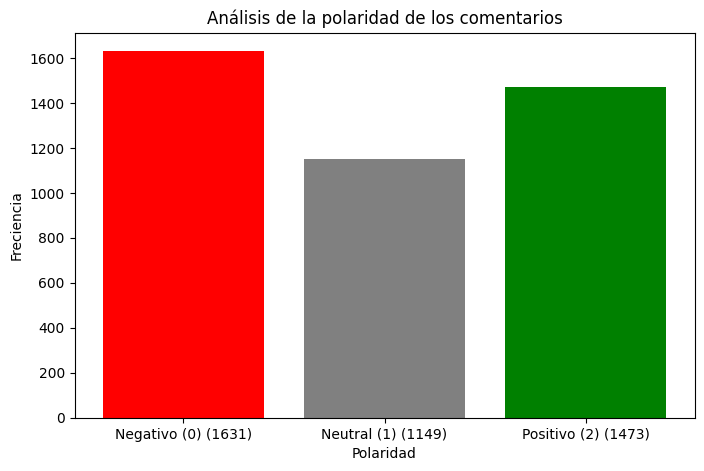

In [ ]:
labels = ['Negativo (0)', 'Neutral (1)', 'Positivo (2)']
polarity_counts = data['Polaridad'].value_counts().sort_index()
polarity_counts_sorted = polarity_counts.sort_index()
adjusted_labels = [f'{label} ({count})' for label, count in zip(labels[:len(polarity_counts_sorted)], polarity_counts_sorted)]

plt.figure(figsize=(8, 5))
plt.bar(adjusted_labels, polarity_counts_sorted, color=['red', 'gray', 'green'] [:len(polarity_counts_sorted)])

plt.title('Análisis de la polaridad de los comentarios')
plt.xlabel('Polaridad')
plt.ylabel('Freciencia')
plt.show()


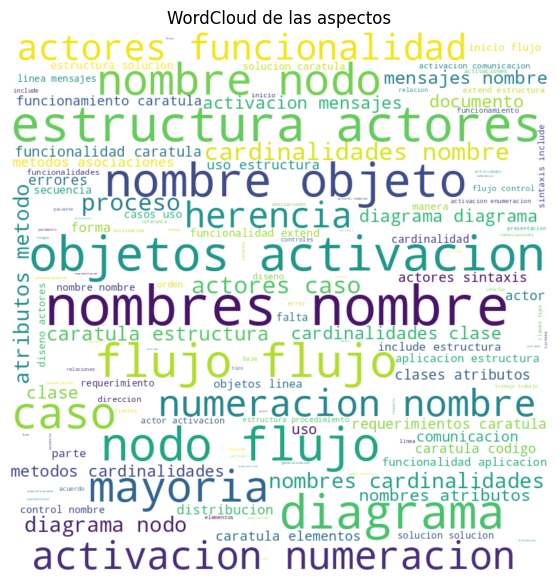

In [ ]:
aspectt_text = " ".join(data['Aspecto'])
wordcloud = WordCloud(width=800, height=800, background_color="white").generate(aspectt_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud de las aspectos")
plt.show()


## Procesamiento de data

In [ ]:
data['Comentario'] = data.apply(lambda row: f"[CLS] {row['Comentario']} [SEP] {row['Aspecto']} [SEP]", axis=1)

## Entrenamiendo del modelo

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe  # DataFrame con los datos
        self.tokenizer = tokenizer  # Tokenizador BERT
        self.max_len = max_len  # Longitud máxima de secuencia

    def __len__(self):
        return len(self.dataframe)  # Número total de muestras en el dataset

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]  # Obtener la fila correspondiente
        sentence = row["Comentario"]  # Extraer el comentario
        label = row["Polaridad"]  # Extraer la etiqueta de polaridad

        # Tokenizar la oración
        encoding = self.tokenizer(
            sentence,
            max_length=self.max_len,
            padding="max_length",  # Rellenar hasta max_len
            truncation=True,  # Truncar si excede max_len
            return_tensors="pt",  # Devolver tensores de PyTorch
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Tensor de IDs de entrada
            "attention_mask": encoding["attention_mask"].squeeze(0),  # Máscara de atención
            "label": torch.tensor(label, dtype=torch.long),  # Etiqueta de salida como tensor
        }


In [ ]:
# Proporciones para las divisiones
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Dividir el dataset en entrenamiento y prueba inicialmente
train_data, test_data = train_test_split(data, test_size=(1 - train_size), random_state=42)

# Ajustar la proporción para dividir entre validación y prueba
val_data, test_data = train_test_split(test_data, test_size=(test_size / (val_size + test_size)), random_state=42)

#Carga de tokenizador BERT
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
max_len = 256
# Crear los datasets
train_dataset = SentimentDataset(train_data, tokenizer, max_len)
val_dataset = SentimentDataset(val_data, tokenizer, max_len)
test_dataset = SentimentDataset(test_data, tokenizer, max_len)

# Crear los DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class BertBiLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, num_labels):
        super(BertBiLSTMClassifier, self).__init__()
        # Cargar el modelo BERT preentrenado
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels
        # Capa LSTM bidireccional
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True, # Hacemos que la LSTM sea bidireccional BiLSTM
        )
        # Capa totalmente conectada para clasificación
        self.fc = nn.Linear(hidden_dim * 2, num_labels)  # *2 debido a bidireccional

    def forward(self, input_ids, attention_mask):
        # Pasar los datos a través de BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Extraer los embeddings ocultos
        hidden_states = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)
        # Pasar los embeddings de BERT a la BiLSTM
        lstm_out, _ = self.lstm(hidden_states)  # (batch_size, seq_len, hidden_dim*2)
        # Usar la representación de la primera posición (CLS) tras la BiLSTM
        cls_representation = lstm_out[:, 0, :]  # (batch_size, hidden_dim*2)
        # Pasar por la capa de clasificación
        logits = self.fc(cls_representation)  # (batch_size, num_labels)
        return logits

In [ ]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Configuraciones del modelo
bert_model_name = "dccuchile/bert-base-spanish-wwm-uncased"
hidden_dim = 256
num_labels = 3
# Instanciar el modelo y moverlo al dispositivo adecuado
model = BertBiLSTMClassifier(bert_model_name, hidden_dim, num_labels)
model.to(device)

# Configuración del optimizador y scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.005)
num_training_steps = len(train_dataloader) * 3  # Número de épocas
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn as nn

def train_one_epoch(model, data_loader, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    loss_fn = nn.CrossEntropyLoss()  # Definir función de pérdida

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids, attention_mask=attention_mask)  # Modelo sin 'labels'
        loss = loss_fn(logits, labels)  # Calcular la pérdida manualmente

        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision, recall, f1

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    loss_fn = nn.CrossEntropyLoss()  # Definir función de pérdida

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask=attention_mask)  # Modelo sin 'labels'
            loss = loss_fn(logits, labels)  # Calcular la pérdida manualmente

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision, recall, f1

In [ ]:
!pip install nvidia-ml-py3

## Entrenamiendo del modelo con 5 epocas


In [ ]:
import time
import torch
import psutil
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetUtilizationRates
nvmlInit()
gpu_handle = nvmlDeviceGetHandleByIndex(0)
# Listas para almacenar métricas

train_losses = []
train_accuracys = []
train_precisions = []
train_recalls = []
train_f1s = []

val_losses = []
val_accuracys = []
val_precisions = []
val_recalls = []
val_f1s = []

cpu_usages = []
ram_usages = []  # Guardaremos valores absolutos de RAM
gpu_usages = []
gpu_memories = []
epochs = 5
start_time = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Capturar métricas antes de la época
    cpu_start = psutil.cpu_percent(interval=None)
    ram_start = psutil.virtual_memory().used / (1024 ** 3)  # RAM en GB

    train_loss, train_accuracy, train_precision, train_recall, train_f1 = train_one_epoch(model, train_dataloader, optimizer, device, lr_scheduler)
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(model, val_dataloader, device)

    # Capturar métricas después de la época
    cpu_end = psutil.cpu_percent(interval=None)
    ram_end = psutil.virtual_memory().used / (1024 ** 3)

    # Calcular valores absolutos
    cpu_usage = (cpu_start + cpu_end) / 2
    ram_used = ram_end  # Ahora guardamos el valor absoluto
    gpu_info = nvmlDeviceGetMemoryInfo(gpu_handle)
    gpu_utilization = nvmlDeviceGetUtilizationRates(gpu_handle)

    gpu_memory = gpu_info.used / (1024 ** 3)
    gpu_usage = gpu_utilization.gpu

    # Almacenar métricas

    train_losses.append(train_loss)
    train_accuracys.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accuracys.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    cpu_usages.append(cpu_usage)
    ram_usages.append(ram_used)  # Guardamos el uso absoluto
    gpu_usages.append(gpu_usage)
    gpu_memories.append(gpu_memory)

    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Training Precision: {train_precision:.4f}, Validation Precision: {val_precision:.4f}")
    print(f"Training Recall: {train_recall:.4f}, Validation Recall: {val_recall:.4f}")
    print(f"Training F1 Score: {train_f1:.4f}, Validation F1 Score: {val_f1:.4f}")

# Métricas finales
end_time = time.time()
total_time = end_time - start_time
avg_cpu = sum(cpu_usages) / len(cpu_usages)
avg_ram = sum(ram_usages) / len(ram_usages)  # Ahora es un promedio real
avg_gpu = sum(gpu_usages) / len(gpu_usages)
avg_gpu_memory = sum(gpu_memories) / len(gpu_memories)

print("\n--- Estadísticas Finales del Entrenamiento ---")
print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos ({total_time / 60:.2f} minutos)")
print(f"Uso promedio de CPU: {avg_cpu:.2f}%")
print(f"Memoria RAM promedio utilizada: {avg_ram:.2f} GB")
print(f"Uso promedio de GPU: {avg_gpu:.2f}%")
print(f"Memoria GPU promedio utilizada: {avg_gpu_memory:.2f} GB")

Epoch 1/5


Evaluation: 100%|██████████| 80/80 [00:10<00:00,  7.95it/s]


Training Loss: 0.4874, Validation Loss: 0.1945
Training Accuracy: 0.7964, Validation Accuracy: 0.9420
Training Precision: 0.7950, Validation Precision: 0.9440
Training Recall: 0.7964, Validation Recall: 0.9420
Training F1 Score: 0.7927, Validation F1 Score: 0.9421
Epoch 2/5


Evaluation: 100%|██████████| 80/80 [00:10<00:00,  8.00it/s]


Training Loss: 0.1362, Validation Loss: 0.1496
Training Accuracy: 0.9597, Validation Accuracy: 0.9498
Training Precision: 0.9600, Validation Precision: 0.9498
Training Recall: 0.9597, Validation Recall: 0.9498
Training F1 Score: 0.9598, Validation F1 Score: 0.9498
Epoch 3/5


Evaluation: 100%|██████████| 80/80 [00:09<00:00,  8.02it/s]


Training Loss: 0.0660, Validation Loss: 0.1482
Training Accuracy: 0.9832, Validation Accuracy: 0.9498
Training Precision: 0.9832, Validation Precision: 0.9508
Training Recall: 0.9832, Validation Recall: 0.9498
Training F1 Score: 0.9832, Validation F1 Score: 0.9502
Epoch 4/5


Evaluation: 100%|██████████| 80/80 [00:09<00:00,  8.02it/s]


Training Loss: 0.0496, Validation Loss: 0.1482
Training Accuracy: 0.9893, Validation Accuracy: 0.9498
Training Precision: 0.9893, Validation Precision: 0.9508
Training Recall: 0.9893, Validation Recall: 0.9498
Training F1 Score: 0.9893, Validation F1 Score: 0.9502
Epoch 5/5


Evaluation: 100%|██████████| 80/80 [00:10<00:00,  7.97it/s]

Training Loss: 0.0509, Validation Loss: 0.1482
Training Accuracy: 0.9882, Validation Accuracy: 0.9498
Training Precision: 0.9884, Validation Precision: 0.9508
Training Recall: 0.9882, Validation Recall: 0.9498
Training F1 Score: 0.9883, Validation F1 Score: 0.9502

--- Estadísticas Finales del Entrenamiento ---
Tiempo total de entrenamiento: 731.25 segundos (12.19 minutos)
Uso promedio de CPU: 41.80%
Memoria RAM promedio utilizada: 2.32 GB
Uso promedio de GPU: 91.60%
Memoria GPU promedio utilizada: 4.88 GB


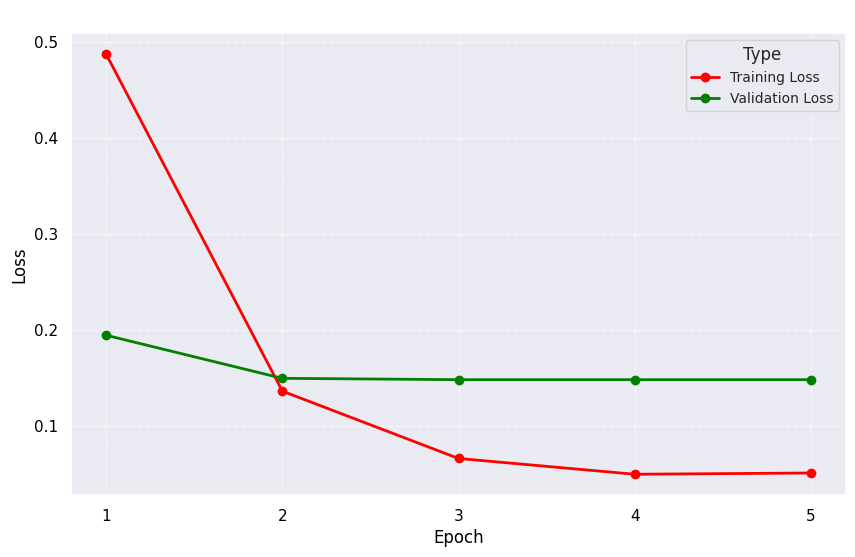

In [ ]:
import seaborn as sns

# Configurar estilo de Seaborn para fondo oscuro
sns.set(style="darkgrid")

# Graficar las pérdidas con líneas y marcadores
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', color='red', linestyle='-', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o', color='green', linestyle='-', linewidth=2)

# Personalizar la gráfica
plt.title('Training and Validation Loss per Epoch', fontsize=14, color='white')
plt.xlabel('Epoch', fontsize=12, color='black')
plt.ylabel('Loss', fontsize=12, color='black')
plt.xticks(range(1, epochs + 1), color='black')  # Etiquetas de las épocas en el eje X
plt.yticks(color='black')  # Etiquetas del eje Y
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Type', fontsize=10, title_fontsize=12, loc='upper right')

# Cambiar fondo de la gráfica a oscuro
plt.show()


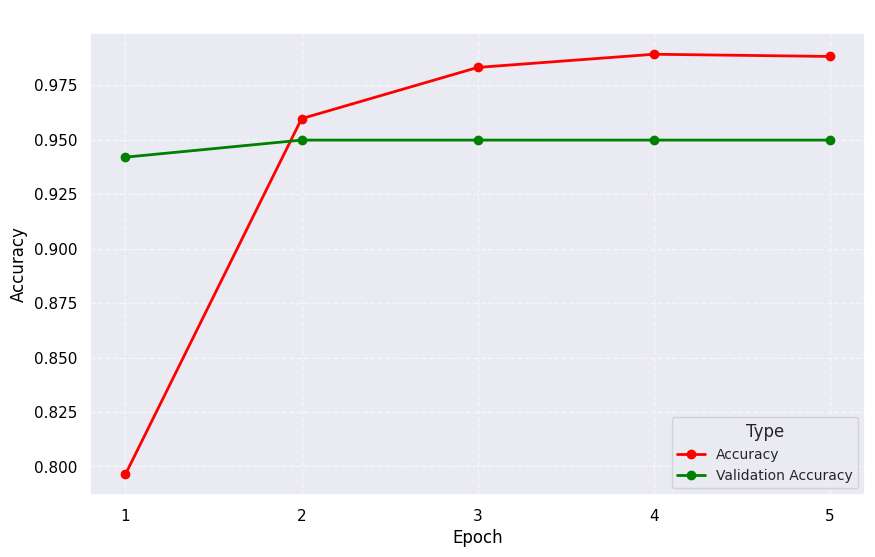

In [ ]:
import seaborn as sns

# Configurar estilo de Seaborn para fondo oscuro
sns.set(style="darkgrid")

# Graficar las pérdidas con líneas y marcadores
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracys, label='Accuracy', marker='o', color='red', linestyle='-', linewidth=2)
plt.plot(range(1, epochs + 1), val_accuracys, label='Validation Accuracy', marker='o', color='green', linestyle='-', linewidth=2)

# Personalizar la gráfica
plt.title('Training and Validation Accuracy per Epoch', fontsize=14, color='white')
plt.xlabel('Epoch', fontsize=12, color='black')
plt.ylabel('Accuracy', fontsize=12, color='black')
plt.xticks(range(1, epochs + 1), color='black')  # Etiquetas de las épocas en el eje X
plt.yticks(color='black')  # Etiquetas del eje Y
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Type', fontsize=10, title_fontsize=12, loc='lower right')

# Cambiar fondo de la gráfica a oscuro
plt.show()

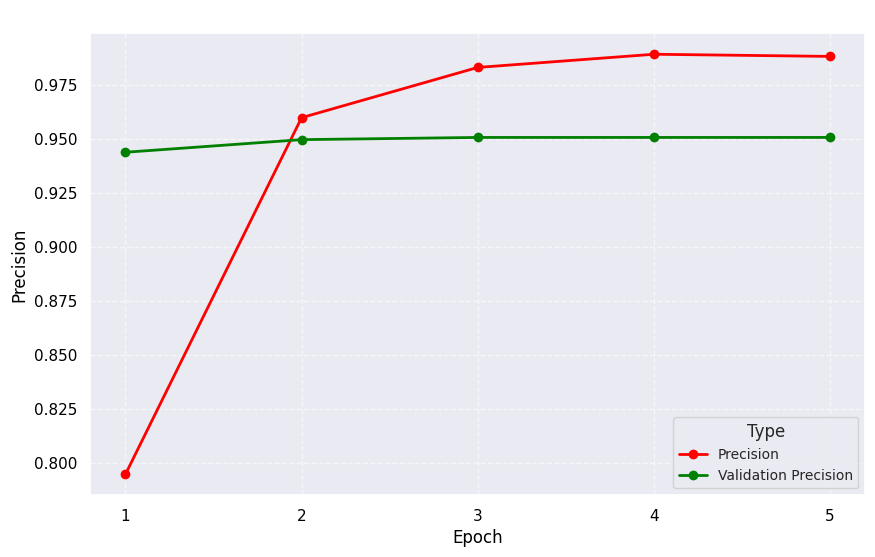

In [ ]:
import seaborn as sns

# Configurar estilo de Seaborn para fondo oscuro
sns.set(style="darkgrid")

# Graficar las pérdidas con líneas y marcadores
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_precisions, label='Precision', marker='o', color='red', linestyle='-', linewidth=2)
plt.plot(range(1, epochs + 1), val_precisions, label='Validation Precision', marker='o', color='green', linestyle='-', linewidth=2)

# Personalizar la gráfica
plt.title('Training and Validation Precision per Epoch', fontsize=14, color='white')
plt.xlabel('Epoch', fontsize=12, color='black')
plt.ylabel('Precision', fontsize=12, color='black')
plt.xticks(range(1, epochs + 1), color='black')  # Etiquetas de las épocas en el eje X
plt.yticks(color='black')  # Etiquetas del eje Y
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Type', fontsize=10, title_fontsize=12, loc='lower right')

# Cambiar fondo de la gráfica a oscuro
plt.show()

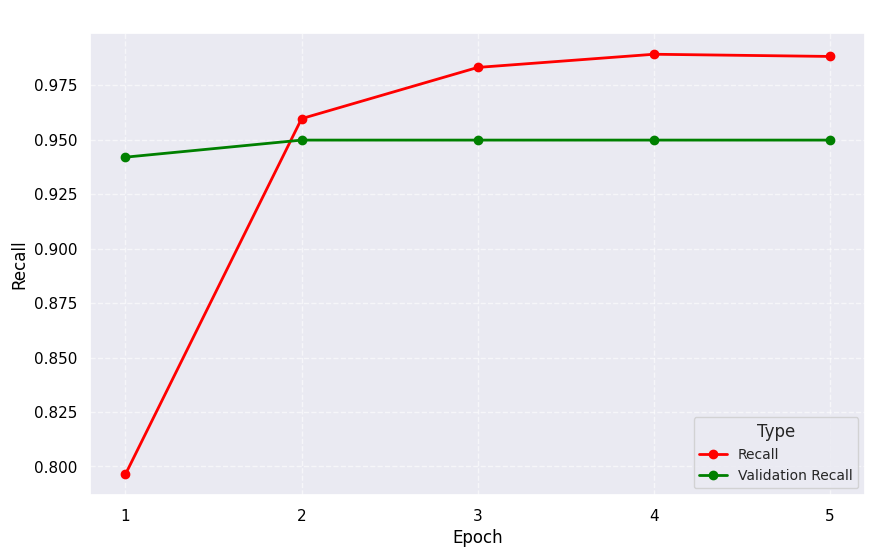

In [ ]:
import seaborn as sns

# Configurar estilo de Seaborn para fondo oscuro
sns.set(style="darkgrid")

# Graficar las pérdidas con líneas y marcadores
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_recalls, label='Recall', marker='o', color='red', linestyle='-', linewidth=2)
plt.plot(range(1, epochs + 1), val_recalls, label='Validation Recall', marker='o', color='green', linestyle='-', linewidth=2)

# Personalizar la gráfica
plt.title('Training and Validation Recall per Epoch', fontsize=14, color='white')
plt.xlabel('Epoch', fontsize=12, color='black')
plt.ylabel('Recall', fontsize=12, color='black')
plt.xticks(range(1, epochs + 1), color='black')  # Etiquetas de las épocas en el eje X
plt.yticks(color='black')  # Etiquetas del eje Y
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Type', fontsize=10, title_fontsize=12, loc='lower right')

# Cambiar fondo de la gráfica a oscuro
plt.show()

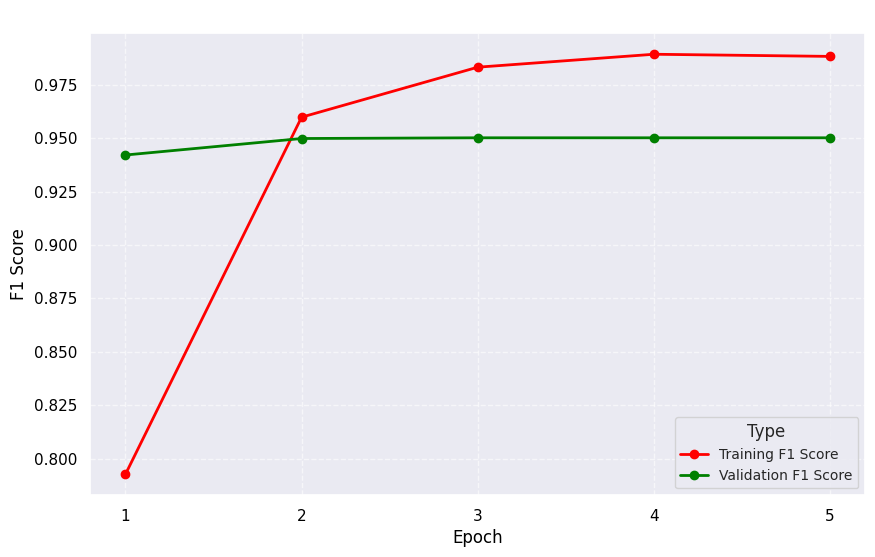

In [ ]:
import seaborn as sns

# Configurar estilo de Seaborn para fondo oscuro
sns.set(style="darkgrid")

# Graficar las pérdidas con líneas y marcadores
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_f1s, label='Training F1 Score', marker='o', color='red', linestyle='-', linewidth=2)
plt.plot(range(1, epochs + 1), val_f1s, label='Validation F1 Score', marker='o', color='green', linestyle='-', linewidth=2)

# Personalizar la gráfica
plt.title('Training and Validation F1 Score per Epoch', fontsize=14, color='white')
plt.xlabel('Epoch', fontsize=12, color='black')
plt.ylabel('F1 Score', fontsize=12, color='black')
plt.xticks(range(1, epochs + 1), color='black')  # Etiquetas de las épocas en el eje X
plt.yticks(color='black')  # Etiquetas del eje Y
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Type', fontsize=10, title_fontsize=12, loc='lower right')

# Cambiar fondo de la gráfica a oscuro
plt.show()

## Guardar el modelo

In [ ]:
save_directory = "ABSA_Bert+BiLstm"
os.makedirs(save_directory, exist_ok=True)

# Guarda los pesos del modelo
torch.save(model.state_dict(), f"{save_directory}/model_weights.pth")

print(f"Pesos del modelo guardados en {save_directory}/model_weights.pth")
tokenizer.save_pretrained(save_directory)
print(f"Modelo Tokenizado '{save_directory}' guardado!!!")

Pesos del modelo guardados en ABSA_Bert+BiLstm/model_weights.pth
Modelo Tokenizado 'ABSA_Bert+BiLstm' guardado!!!


## Proceso de prueba

In [ ]:
# Función para evaluar el modelo sobre un conjunto de prueba
def test_model(model, data_loader, device, class_names):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs
            preds = torch.argmax(logits, dim=1)  # Obtener la clase con mayor probabilidad
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    precision = precision_score(true_labels, predictions, average="weighted", zero_division=0)
    # Generar informe detallado por clase
    report = classification_report(true_labels, predictions, target_names=class_names, zero_division=0)
    return accuracy, precision, f1, report
# Lista de nombres de las clases en el mismo orden que las etiquetas
class_names = ["Negativo", "Neutral", "Positivo"]
# Ejecutar la evaluación del modelo
test_accuracy, test_precision, test_f1, test_report = test_model(model, test_dataloader, device, class_names)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test F1 Score: {test_f1:.4f}")
print("\nDetailed Classification Report:")
print(test_report)

Test Accuracy: 0.9545, Test Precision: 0.9566, Test F1 Score: 0.9551

Detailed Classification Report:
              precision    recall  f1-score   support

    Negativo       0.98      0.95      0.97       238
     Neutral       0.89      0.96      0.92       171
    Positivo       0.98      0.95      0.97       229

    accuracy                           0.95       638
   macro avg       0.95      0.95      0.95       638
weighted avg       0.96      0.95      0.96       638



## Pueba del modelo

In [ ]:
# Función para predecir el sentimiento asociado a un aspecto en un comentario
def predict_aspect_sentiment(model, tokenizer, text, aspect, device, max_len=128):
    model.eval()

    # Codificar el texto y el aspecto juntos
    inputs = tokenizer(
        text,
        aspect,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors="pt"
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs
        predicted_class = torch.argmax(logits, dim=1).item()

    # Mapeo de la clase predicha a un sentimiento
    label_mapping_reverse = {
        0: "Negativo",
        1: "Neutral",
        2: "Positivo"
    }

    sentiment = label_mapping_reverse[predicted_class]
    return sentiment


In [ ]:
!python -m spacy download es_core_news_sm
import spacy
# Cargar modelo de procesamiento de lenguaje natural de spaCy para español
nlp = spacy.load("es_core_news_sm")

# Función para extraer el primer aspecto de un comentario
def extract_aspect(comment):
    doc = nlp(comment)
    for token in doc:
        # Buscar el primer sustantivo
        if token.pos_ in ("NOUN"):
            return token.text
    return None  # Si no se encuentra ningún sustantivo, devolver None

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 54.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
text = "Los sistemas empresariales están descritos de manera parcialmente correcta, le falta detallar el tipo de gestión."
aspect = extract_aspect(text)

predicted_sentiment = predict_aspect_sentiment(
    model, tokenizer, text, aspect, device
)

print(f"Comentario: {text}")
print(f"Aspecto: {aspect}")
print(f"Sentimiento Predicho: {predicted_sentiment}")

Comentario: Los sistemas empresariales están descritos de manera parcialmente correcta, le falta detallar el tipo de gestión.
Aspecto: sistemas
Sentimiento Predicho: Neutral
